In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/ygrene/dataset/'

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
solar_df = pd.read_csv(data_path+ 'solar_power_2204.csv')
solar_df

,datetime,target
0,2020-09-10 0:00,NaN
1,2020-09-10 0:10,NaN
2,2020-09-10 0:20,NaN
3,2020-09-10 0:30,NaN
4,2020-09-10 0:40,NaN
...,...,...
86107,2022-04-30 23:10,0.0
86108,2022-04-30 23:20,0.0
86109,2022-04-30 23:30,0.0
86110,2022-04-30 23:40,0.0


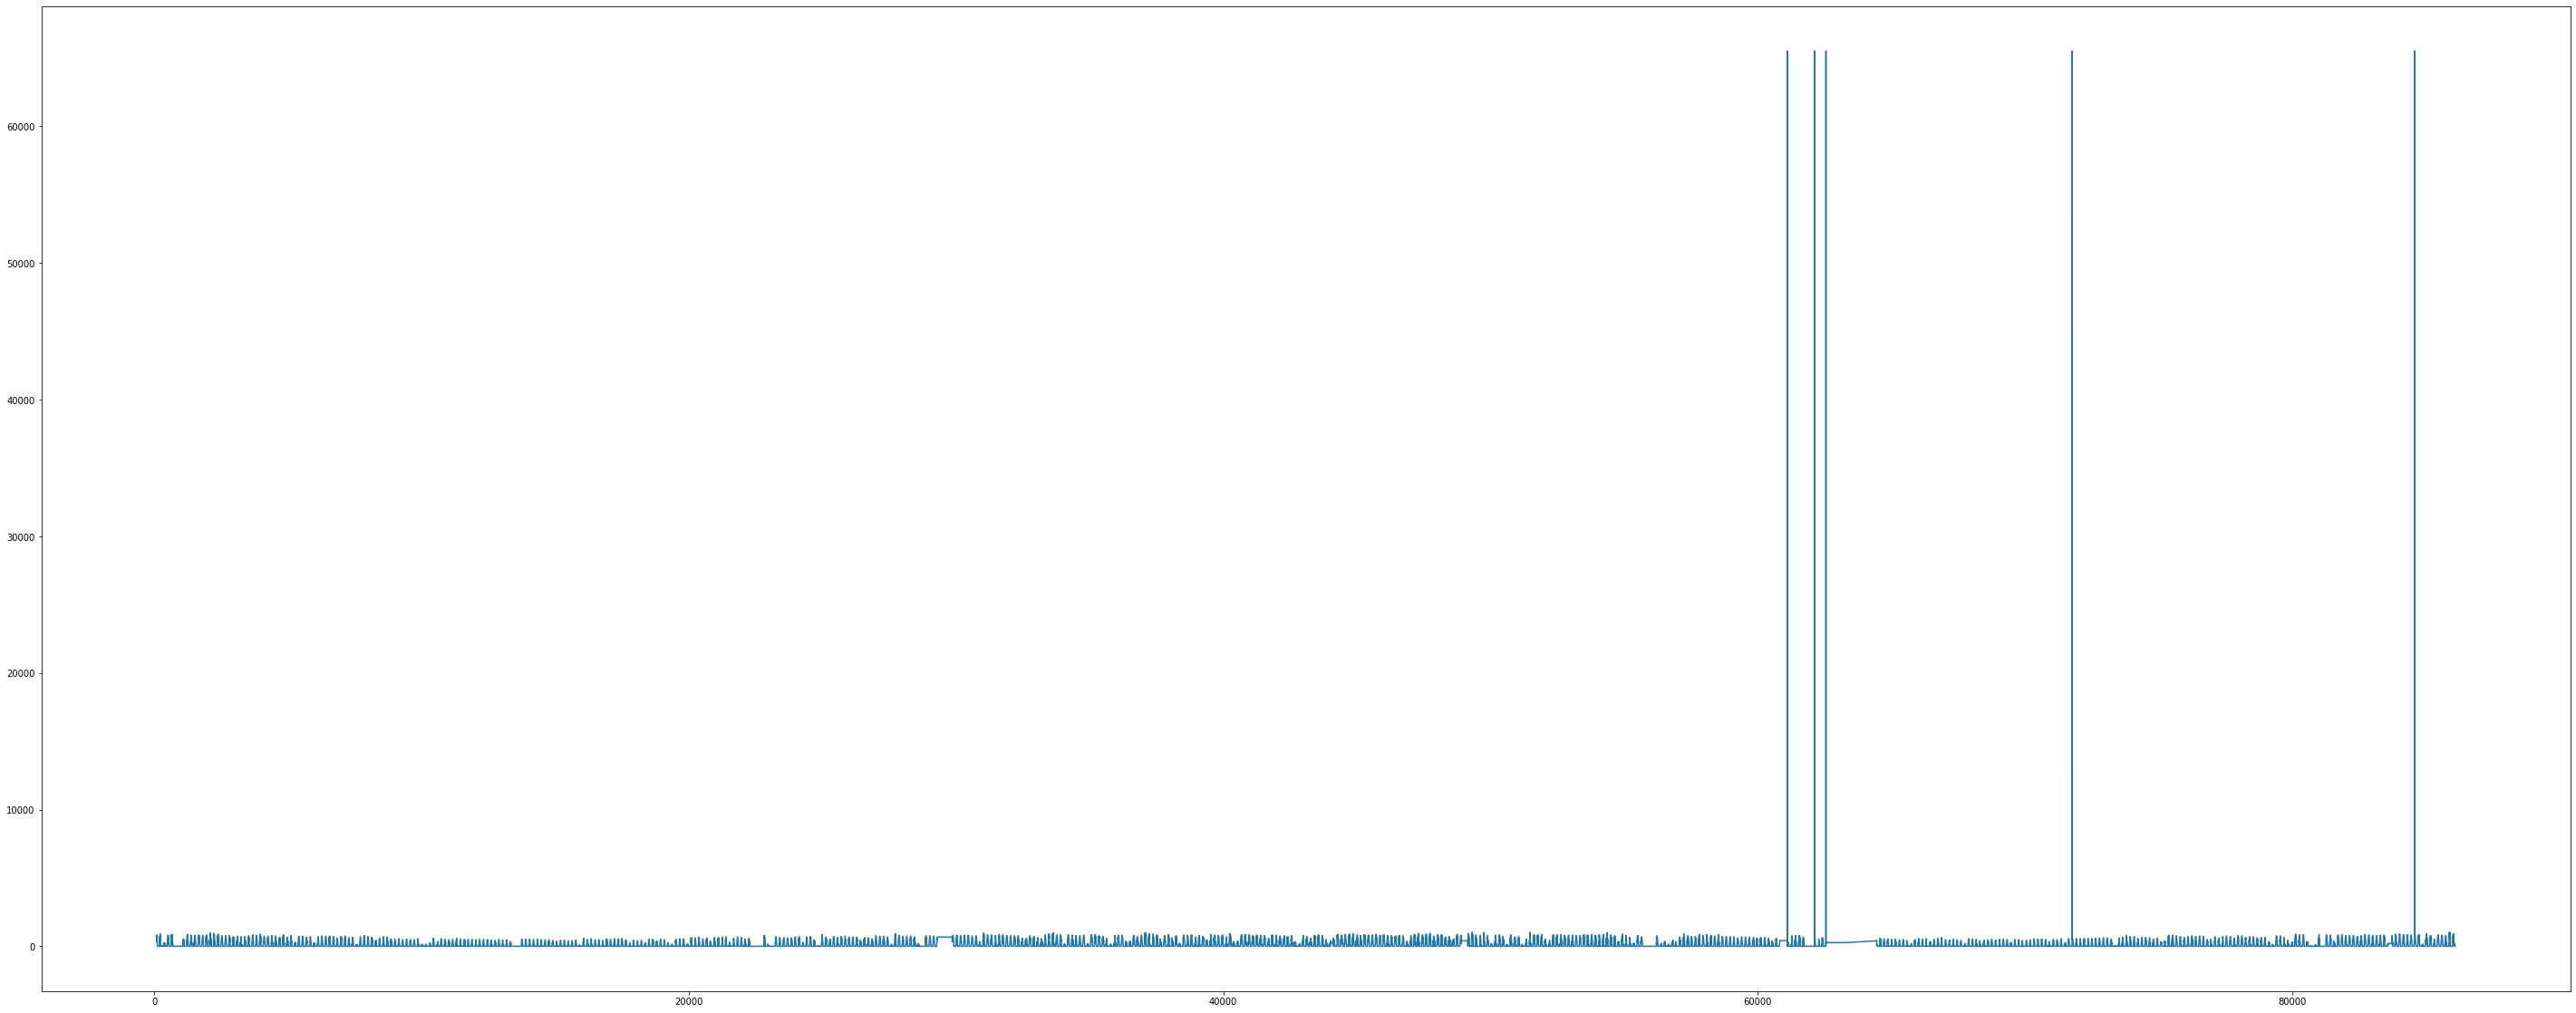

In [ ]:
plt.figure(figsize=(50,20))
plt.plot(solar_df['target'])

In [ ]:
# 1. 다음 해 데이터로 대체
solar_df['target'][42: 67] = solar_df['target'][52602:52627] # 2020-09-10 NaN값
solar_df['target'] = solar_df['target'].fillna(0)

# 2-3. 전년도 데이터로 대체
solar_df['target'][60831:61118] = solar_df['target'][8271:8558] # 2021-11-06 10:30 ~ 2021-11-08 10:10 <- 2020-11-06 10:30 ~ 2020-11-08 10:10
solar_df['target'][62562: 64458] = solar_df['target'][10002:11898] # 2021-11-18 11:00 ~ 2021-12-01 14:50 <- 2020-11-18 11:00 ~ 2020-12-01 14:50

# 4. outlier max값으로 대체(오버플로우)
outlier_list = solar_df.index[(solar_df['target'] == 65535.0)].to_list()
for i in outlier_list:
  solar_df['target'].iloc[i] = 0
for i in outlier_list:
  solar_df['target'].iloc[i] = max(solar_df['target'])

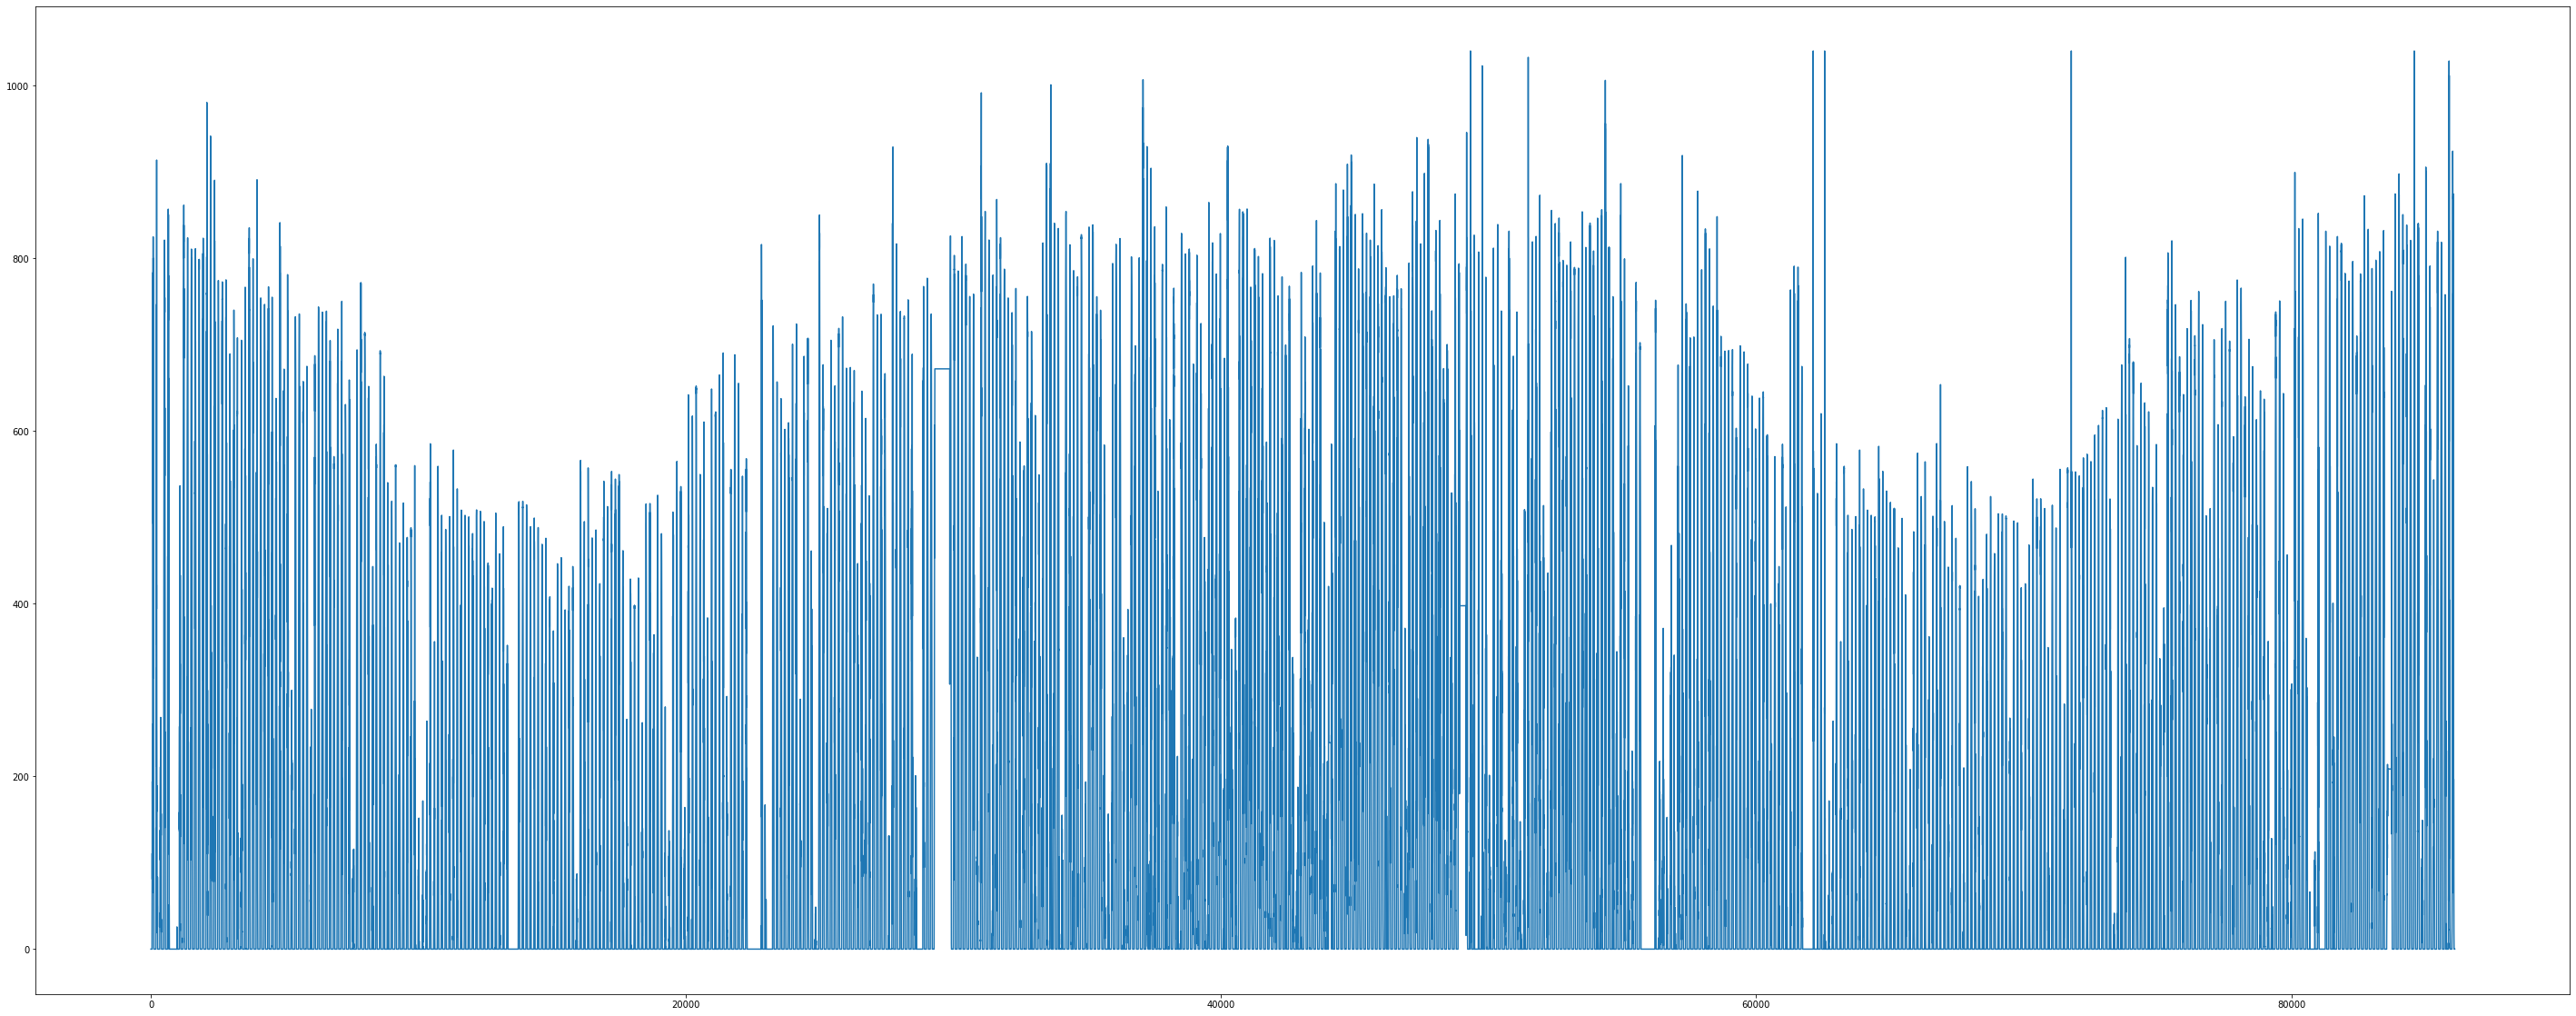

In [ ]:
plt.figure(figsize=(50,20))
plt.plot(solar_df['target'])

In [ ]:
# datetime 인덱스로 변환
solar_df['datetime'] = pd.DatetimeIndex(pd.to_datetime(solar_df['datetime'], format='%Y-%m-%d %H:%M:%S'))
solar_df = solar_df.set_index('datetime')

# 5. 하루 단위로 없는 데이터가 존재 -> 해당 데이터의 전년도 or 다음연도 데이터로 대체
tmp = solar_df.between_time('6:00:00', '21:00:00')
tmp2 = tmp.resample(rule='D').sum() == 0
for date in tmp2[tmp2['target'] == True].index:
  date = str(date) # 2020 : [09-15, 12-12, 12-13] 2021: [02-12, 02-13, 02-14, 02-17, 03-28, 10-02, 10-03, 10-04, 11-13, 11-14], 2022 : [03-27]
  if date[:4] == '2020':
    solar_df.loc[f'{date} 00:00:00': f'{date} 23:50:00'] = solar_df.loc[f'2021{date[4:10]} 00:00:00': f'2021{date[4:10]} 23:50:00'].values
  elif date[:4] == '2021' and int(date[5:7]) < 10:
    solar_df.loc[f'{date} 00:00:00': f'{date} 23:50:00'] = solar_df.loc[f'2022{date[4:10]} 00:00:00': f'2022{date[4:10]} 23:50:00'].values
  elif date[:4] == '2021' and int(date[5:7]) >= 10:
    solar_df.loc[f'{date} 00:00:00': f'{date} 23:50:00'] = solar_df.loc[f'2020{date[4:10]} 00:00:00': f'2020{date[4:10]} 23:50:00'].values
  elif date[:4] == '2022':
    solar_df.loc[f'{date} 00:00:00': f'{date} 23:50:00'] = solar_df.loc[f'2021{date[4:10]} 00:00:00': f'2021{date[4:10]} 23:50:00'].values

# 6 연속된 값을 작년 or 내년 데이터로 변환
solar_df.loc['2021-04-01 11:20:00':'2021-04-05 08:10:00'] = solar_df.loc['2022-04-01 11:20:00':'2022-04-05 08:10:00'].values
solar_df.loc['2021-07-12 16:30:00':'2021-07-13 09:10:00'] = solar_df.loc['2021-07-05 16:30:00':'2021-07-06 09:10:00'].values # 전 주에 있는 동일 날짜
solar_df.loc['2021-08-15 16:50:00':'2021-08-17 08:30:00'] = solar_df.loc['2021-08-08 16:50:00':'2021-08-10 08:30:00'].values # 전 주에 있는 동일 날짜
solar_df.loc['2022-04-13 13:40:00':'2022-04-14 13:30:00'] = solar_df.loc['2021-04-13 13:40:00':'2021-04-14 13:30:00'].values

# 밑에 구하는 코드 있음

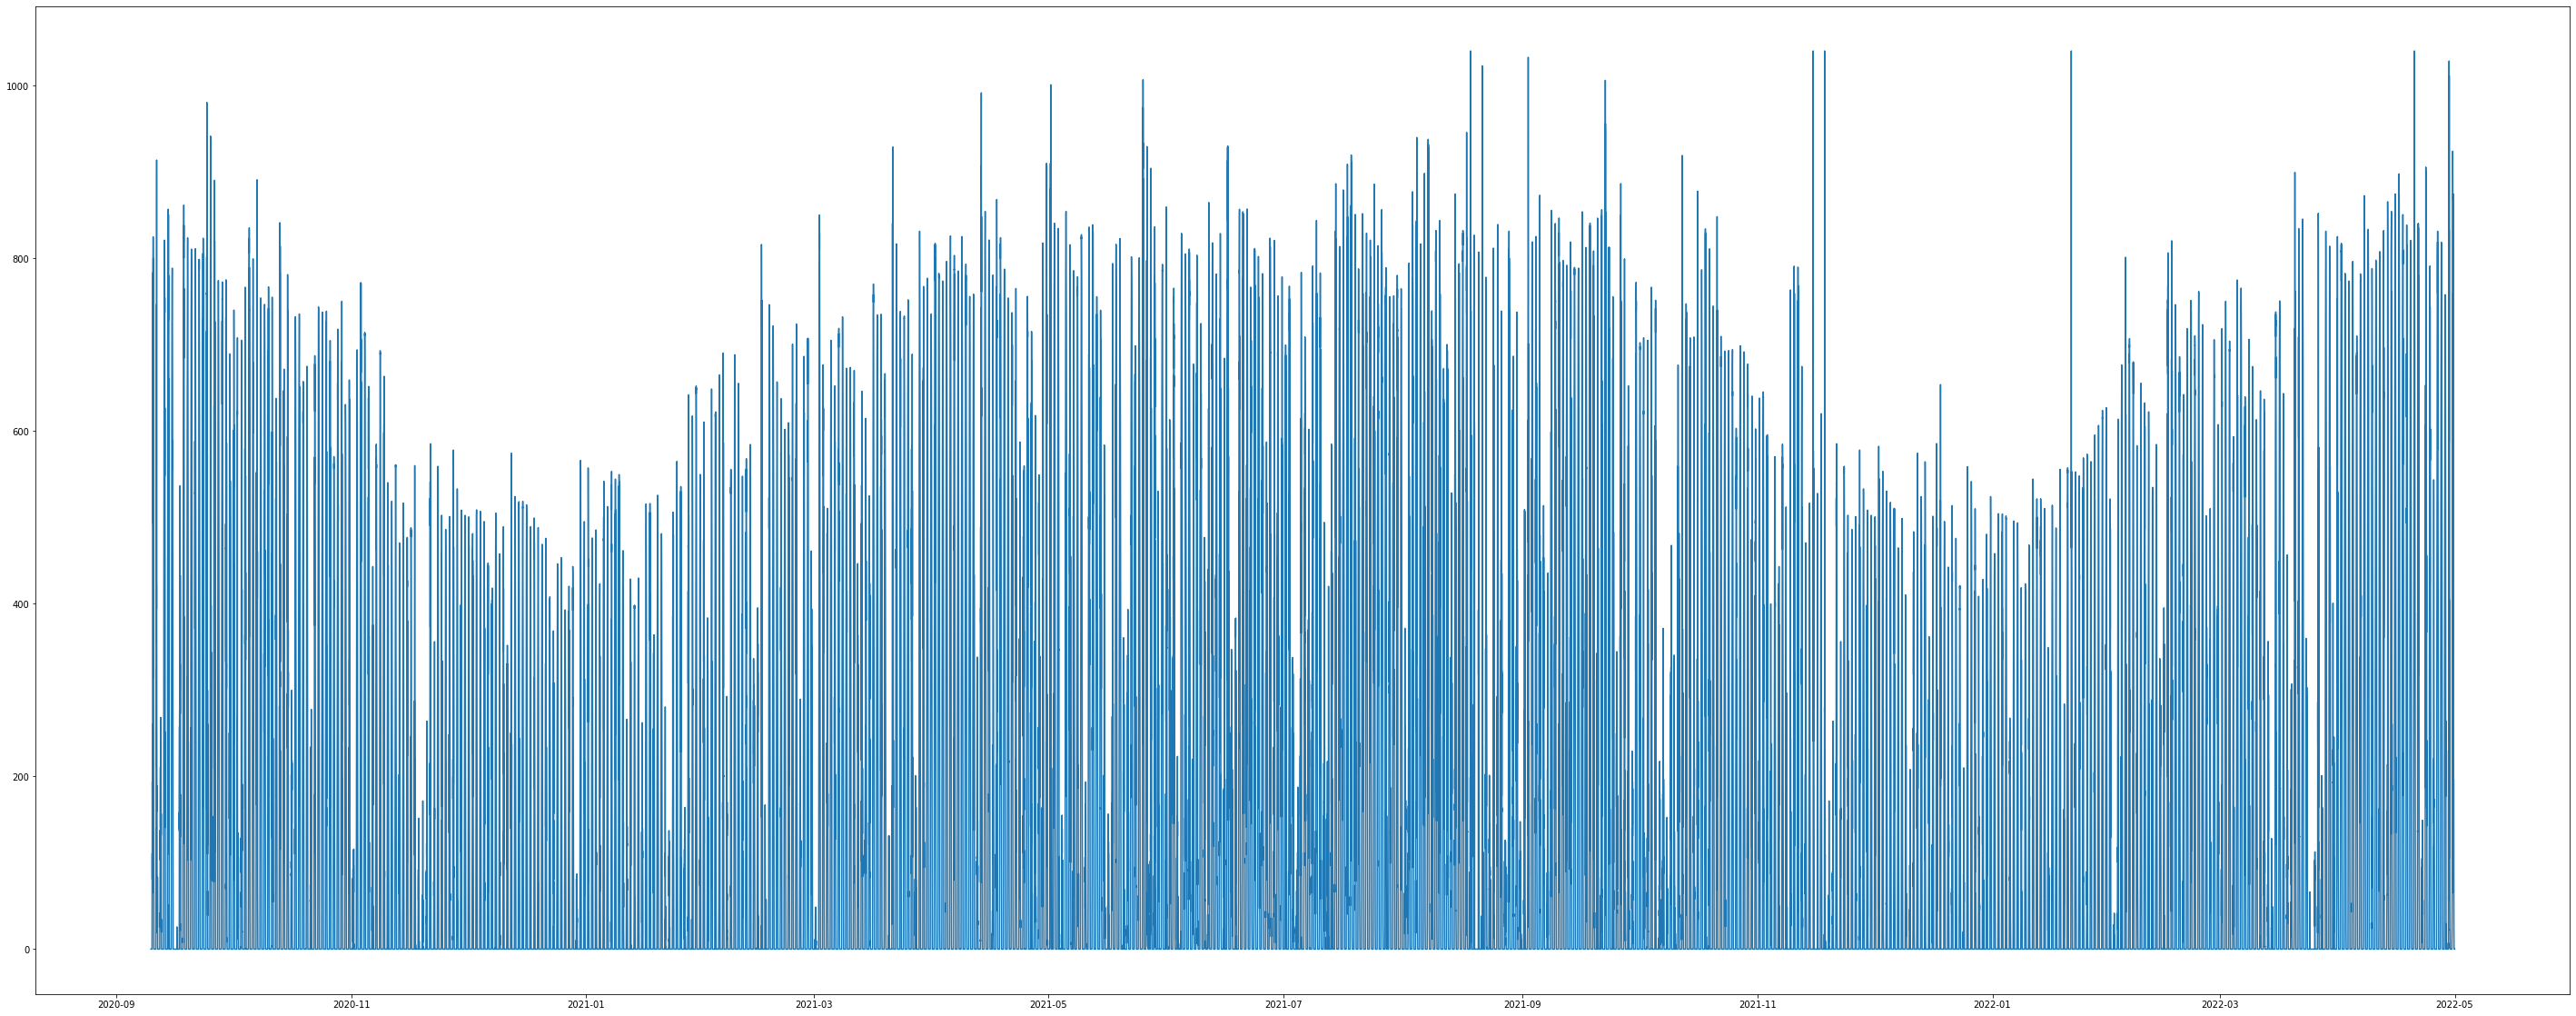

In [ ]:
plt.figure(figsize=(50,20))
plt.plot(solar_df['target'])

In [ ]:
## 연속된 값 찾는 코드

dp = []
result = []
for i in range(1,len(solar_df)):
  print(solar_df['target'].iloc[i])
  if solar_df['target'].iloc[i] != 0.0 and solar_df['target'].iloc[i+1] == solar_df['target'].iloc[i] and solar_df['target'].iloc[i+2] == solar_df['target'].iloc[i]:
    dp.append(solar_df['target'].iloc[i])
    if len(dp) > 4:
      result.append(i)
  else:
    dp = []

# result에서 나온 값을 iloc에 넣기
# solar_df[값-4:값+3]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
0.0
0.0
0.0
5.05
4.9
19.65
31.04
54.0
81.18
52.79
35.43
46.88
43.84
40.11
33.62
15.47
66.66
33.44
36.13
15.9
28.46
51.52
55.01
82.14
116.96
176.4
200.87
87.41
90.6
23.37
74.68
94.09
19.4
24.42
48.66
66.81
19.64
50.65
50.31
56.69
80.54
23.56
26.4
49.02
40.25
59.72
71.01
40.01
25.1
118.76
164.09
104.1
32.77
17.02
17.67
17.59
0.0
40.27
0.68
4.05
0.34
3.31
23.56
0.08
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
360.95
326.4
509.37
539.35
566.67
596.7
623.48
643.35
657.6
684.85
703.56
720.97
744.14
762.91
777.28
786.57
800.8
808.02
818.33
824.87
825.48
831.52
827.86
822.95
822.48
816.18
812.95
799.68
797.37
787.19
775.98
763.7

In [ ]:
solar_df.iloc[29300:29858]

,target
datetime,
2021-04-01 11:20:00,751.88
2021-04-01 11:30:00,760.54
2021-04-01 11:40:00,773.52
2021-04-01 11:50:00,783.22
2021-04-01 12:00:00,793.15
...,...
2021-04-05 07:30:00,71.38
2021-04-05 07:40:00,91.72
2021-04-05 07:50:00,115.68


In [ ]:
solar_df.loc['2021-04-01 11:20:00':'2021-04-05 08:10:00']

,target
datetime,
2021-04-01 11:20:00,751.88
2021-04-01 11:30:00,760.54
2021-04-01 11:40:00,773.52
2021-04-01 11:50:00,783.22
2021-04-01 12:00:00,793.15
...,...
2021-04-05 07:30:00,71.38
2021-04-05 07:40:00,91.72
2021-04-05 07:50:00,115.68


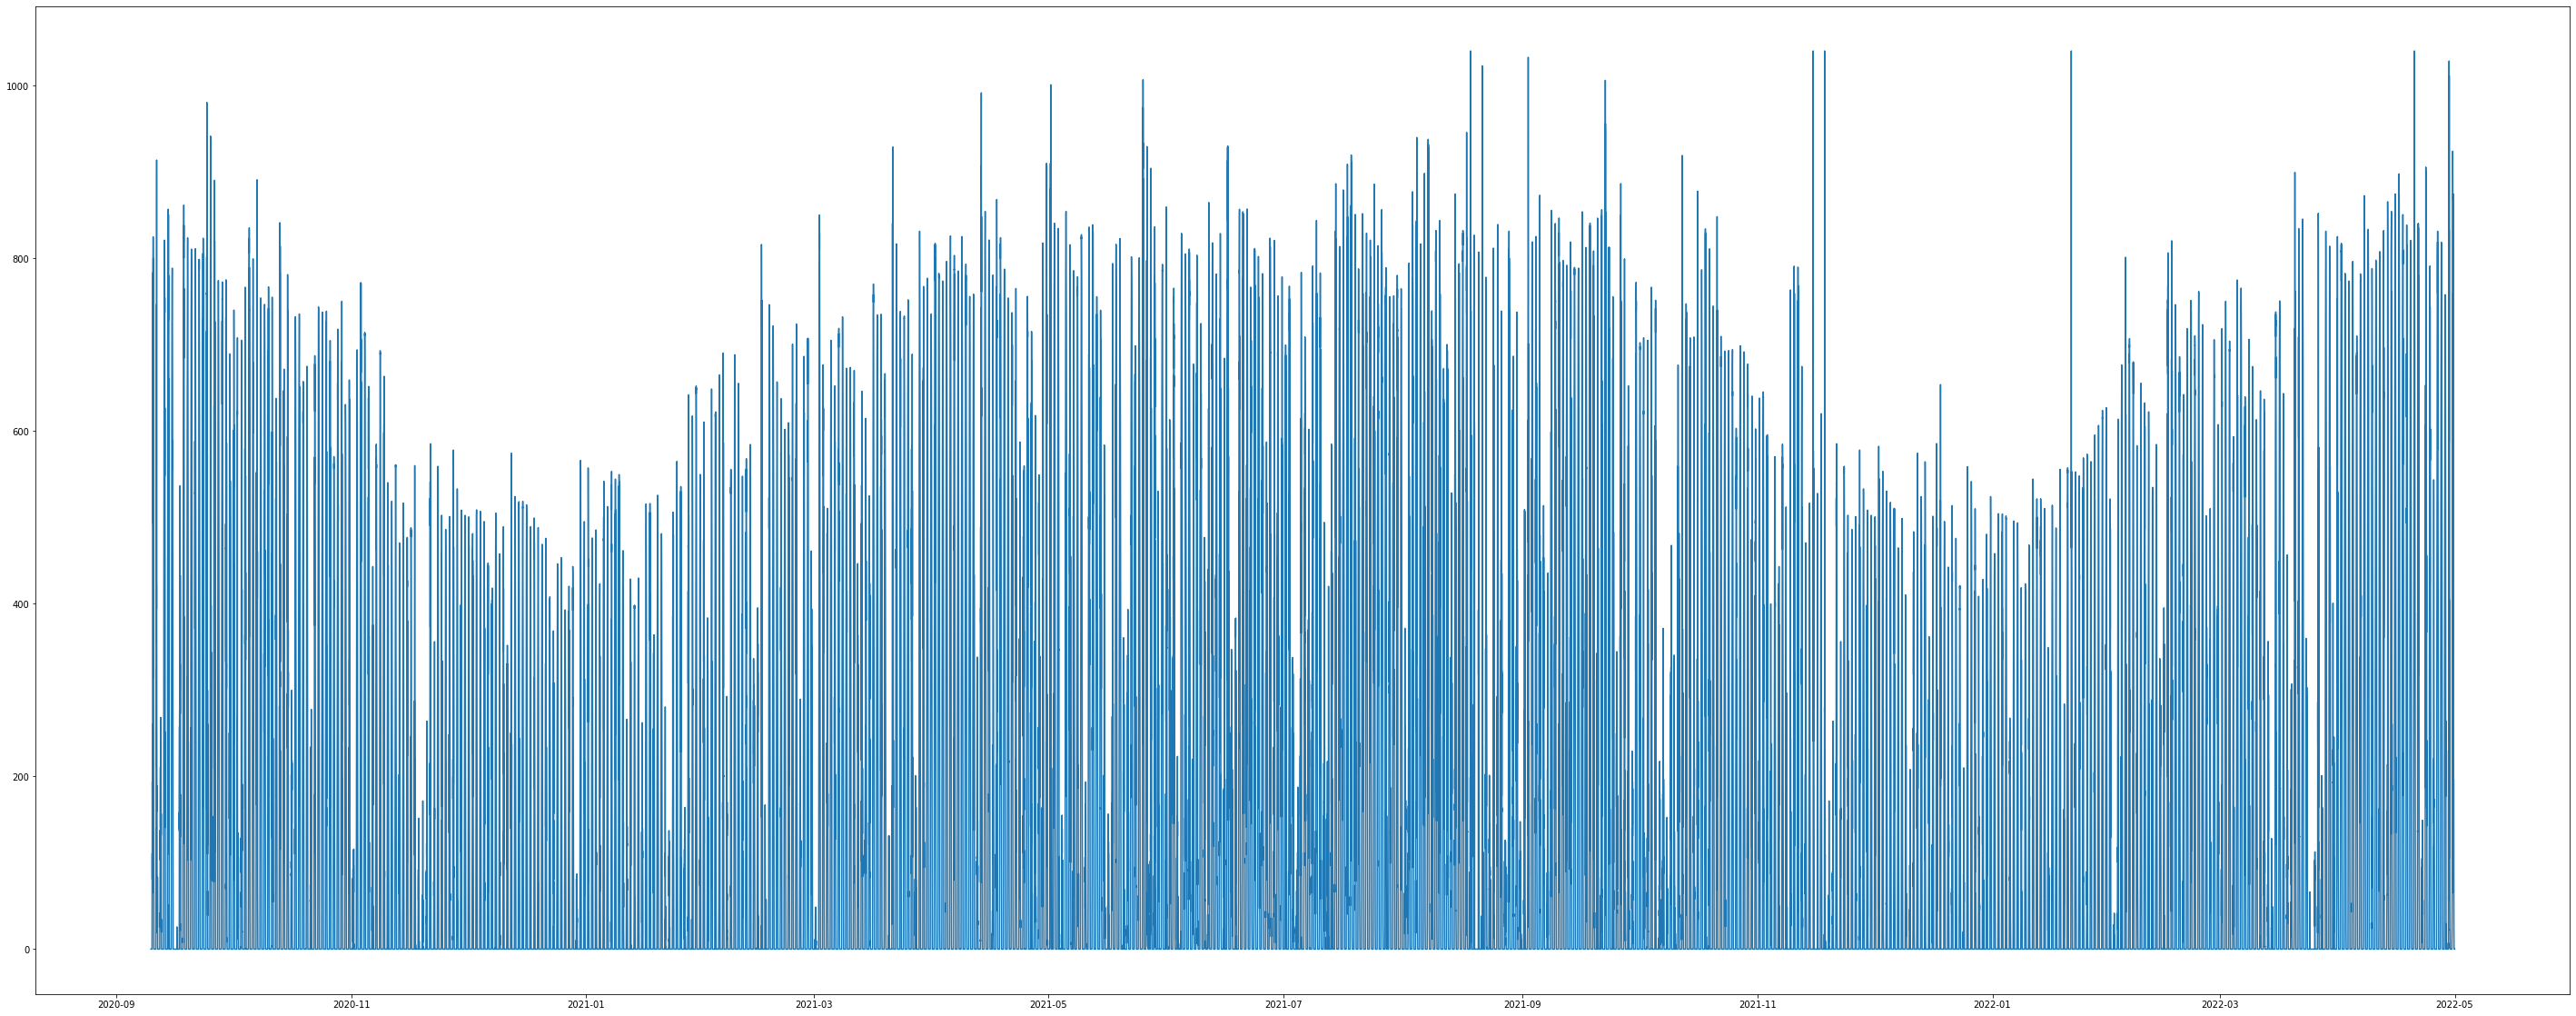

In [ ]:
plt.figure(figsize=(50,20))
plt.plot(solar_df['target'])

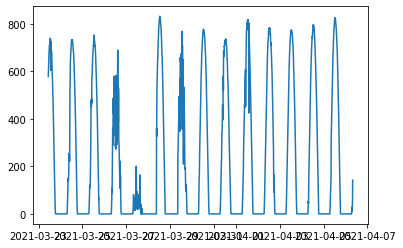

In [ ]:
plt.plot(solar_df['target'][28000:30000]) 

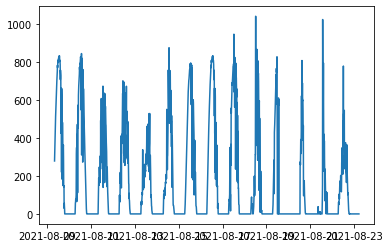

In [ ]:
plt.plot(solar_df['target'][48000:50000])

In [ ]:
solar_df[48921-4:49153+3]

,target
datetime,
2021-08-15 16:50:00,99.72
2021-08-15 17:00:00,112.00
2021-08-15 17:10:00,225.28
2021-08-15 17:20:00,330.49
2021-08-15 17:30:00,387.26
...,...
2021-08-17 07:50:00,236.00
2021-08-17 08:00:00,315.99
2021-08-17 08:10:00,349.75


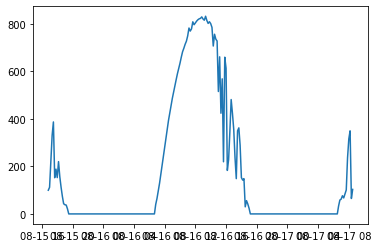

In [ ]:
plt.plot(solar_df['target'][48921-4:49153+3]) 

In [ ]:
solar_df.to_csv('/content/drive/MyDrive/ygrene/solar_데이터비교2/solar_target_timeseriesed.csv')